<a href="https://colab.research.google.com/github/SilahicAmil/End-To-End-SkimLit/blob/main/End_To_End_SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2: Skim Lit

### Purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

 * The paper we're replicating ( [Arxiv](https://arxiv.org/abs/1710.06071))

* Reading through the paper above we see that the model architecture that they use to achieve their best reuslts is available here: [Arxiv](https://arxiv.org/abs/1612.05251)


## Confirm to access to GPU

In [1]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-2ba476a0-9dd0-a33c-71dd-0150c4f227b9)


## Get the data

Since we'll be replication the paper above (PubMed 200k RCT). Lets download the dataset they used.

We can do so from the authors GitHub: [Franck Dernoncourt](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments with 20k Dataset with number replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all filenames in target
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

Now we have some text data, time to become one with the data

One of the best ways to become one with the data is to..

> Visualize, Visualize, Visualize

With that in mind lets, write a function to read in all of the lines of a target text file


In [6]:
# Create function to read lines

def get_lines(filename):

  """

  Reads filename of text and returns lines of text as a list.

  Args:
    filenamne: a string contaning the target filepath

  Returns:
    A list of strings with one string per line from target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read in the training lines

train_lines = get_lines(data_dir+"train.txt") # Read train text lines

train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)


210040

Thinking how we want the data to look

How I think our data would be best represented:

```
[{'line_number' : 0,
    'target' : BACKGROUND,
    'text' : "Emotional eating is associated with overeating and the development of obesity .\n "  # String
    'total_lines': 11},
    ...]
  ```  

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename. Reads contents. Sorts through each line, extracting target label, text of sentence, and how many sentences are in each abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from file
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list

# Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): #Check if an ID Line
      abstract_id = line
      abstract_lines = "" # Reset abstract string if the line is an ID line
    elif line.isspace(): # Check if new line
      abstract_line_split = abstract_lines.splitlines() # Split abstracts into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create empty dictionary
        target_text_split = abstract_line.split("\t") # Split target label from text
        line_data["target"] = target_text_split[0] # Get target label
        line_data["text"] = target_text_split[1].lower() # Get target text and lower
        line_data["line_number"] = abstract_line_number # Number of line in abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess

%%time

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples) , len(val_samples) , len(test_samples))

180040 30212 30135
CPU times: user 531 ms, sys: 105 ms, total: 636 ms
Wall time: 635 ms


In [11]:
# Check first abstract of trining data

train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in format of list of dictionaries. Lets turn it into a DF to visualize it

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Check spread of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

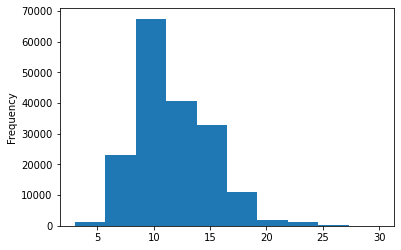

In [14]:
# Check len of different lines

train_df.total_lines.plot.hist();

### Get a list of sentences 

In [15]:
# Convert abstract text to lists

train_sentences = train_df["text"].tolist()

val_sentences = val_df["text"].tolist()

test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View first 10 lines of training

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels



In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label Econcoded Labels

In [18]:
# Extract labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class and map it to text

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 - Baseline Model

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Words -> Numbers
                    ("clf", MultinomialNB()) # Models Text
])

# Fit model
model_0.fit(train_sentences, train_labels_encoded)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
baseline_scores = model_0.score(val_sentences, val_labels_encoded)
print(f"Baseline Models Achieves an Accuracy of: {baseline_scores*100:.2f}%")

Baseline Models Achieves an Accuracy of: 72.18%


In [22]:
# Making Predictions
baseline_predict = model_0.predict(val_sentences)
baseline_predict[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-15 17:32:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-15 17:32:51 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_predict)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing text for sequence models

Before we start building deep sequence models. We have to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [27]:
# How long is each sentence (avg)
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

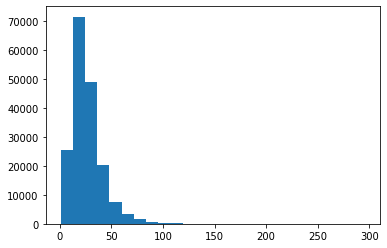

In [28]:
# Whats the distribution?

import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=25);

In [29]:
# How long of a sentence covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Max sequence length
max(sent_lens)

296

## Text Vectorization Layer

In [31]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens= 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Words In Vocab
                                    output_sequence_length=output_seq_len,# Desired output length of vectorized text
                                    pad_to_max_tokens=True) 

In [32]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [33]:
#Test out text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 @ adverse events occurred in the uric acid group and @ in the placebo group , of which @ ( @ % ) and @ ( @ % ) , respectively , were serious adverse events ( p = @ ) .

Length of text: 42

Vectorized text: [[ 118  124  344    5    2 3739  386   13    3    5    2   48   13    4
   126    3   83    9  528  118  124   14    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
# How many words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of text vectorizer

text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

## Custom text embedding

In [36]:
# Create token embedding layers

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Length of vocab
                              output_dim=128, # Different embedding sizes result in drastically different number of params (Similar to n_estimators SciKitLearn)
                              mask_zero=True, # Use masking to handle the variable sequence length (save space/time)
                              name="token_embedding")
 

In [37]:
# Exmaple embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n ")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 @ adverse events occurred in the uric acid group and @ in the placebo group , of which @ ( @ % ) and @ ( @ % ) , respectively , were serious adverse events ( p = @ ) .
Sentence after vectorization:
[[ 118  124  344    5    2 3739  386   13    3    5    2   48   13    4
   126    3   83    9  528  118  124   14    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
 
Sentence after embedding:
 [[[ 0.03437576 -0.04137641 -0.02262147 ... -0.04571884  0.03975557
   -0.00230674]
  [-0.04263049 -0.00460257  0.03611307 ... -0.01755228 -0.03776849
    0.01208577]
  [-0.04756911  0.01645913  0.04440783 ... -0.04695253  0.01693361
   -0.01303867]
  ...
  [ 0.03047467  0.00580328  0.03320011 ...  0.00118661  0.03342774
   -0.03853384]
  [ 0.03047467  0.00580328  0.03320011 ...  0.00118661  0.03342774
   -0.03853384]
  [ 0.03047467  0.00580328  0.03320

## Creating Datasets

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API.

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [39]:
# Take TensorSlice datasets and turn into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D Wth token embed

In [40]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense output

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile MOdel

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [42]:
# Fit the model

hist_model_1 = model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=3,
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 79s 85ms/step - loss: 0.9193 - accuracy: 0.6381 - val_loss: 0.6853 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 48s 86ms/step - loss: 0.6590 - accuracy: 0.7562 - val_loss: 0.6350 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 49s 86ms/step - loss: 0.6169 - accuracy: 0.7756 - val_loss: 0.5970 - val_accuracy: 0.7842


In [43]:
# Evaluate on validation set full
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5996 - accuracy: 0.7862


[0.5995876789093018, 0.7861776947975159]

In [44]:
# Make predictions (makes predictions for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5307073e-01, 1.6094024e-01, 5.7896174e-02, 3.0112109e-01,
         2.6971741e-02],
        [4.0807039e-01, 3.1876984e-01, 1.4831218e-02, 2.4945940e-01,
         8.8690538e-03],
        [1.5125285e-01, 8.5897017e-03, 1.8690547e-03, 8.3827567e-01,
         1.2669363e-05],
        ...,
        [1.5823458e-05, 7.5756275e-04, 1.2047874e-03, 7.2682506e-06,
         9.9801457e-01],
        [5.7504699e-02, 4.8699531e-01, 7.3898360e-02, 7.1657084e-02,
         3.0994460e-01],
        [1.4142190e-01, 7.2420305e-01, 3.7999157e-02, 5.0565593e-02,
         4.5810286e-02]], dtype=float32), (30212, 5))

In [45]:
# Covnert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate results

model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_1_preds)
model_1_results

{'accuracy': 78.61776777439428,
 'f1': 0.7840368271665176,
 'precision': 0.7838703654010716,
 'recall': 0.7861776777439428}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now to use pretrained word embeddings from TensorFlow Hub.

In [48]:
# Download pretrained embedded USE encoder
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Test our pretrained embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:25]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 the @-year cumulative incidence rate of hcc was @ % for non-cirrhotic and @ % for cirrhotic patients ( p < @ ) .
Sentence after embedding:
 [-0.02018819 -0.0045877  -0.02230309 -0.04788099 -0.01966122 -0.00345809
 -0.02051358  0.01941244  0.06783737  0.01377086  0.09807662 -0.07255106
  0.00186374  0.08235819  0.00495841 -0.03183748 -0.09972917  0.04269285
 -0.00904742 -0.06609917 -0.00824527  0.03933086  0.01038746 -0.02151088
  0.01543612]
Length of sentence embedding: 512


## Building and fitting and NLP feature extraction model using USE


In [50]:
# Define feature extraction model

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# YOU COULD ADD MORE LAYERS HERE
outputs= layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extract")

#Compile model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extract"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit the model to data

hist_model_2 = model_2.fit(train_dataset,
                           epochs=3,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 15ms/step - loss: 0.9185 - accuracy: 0.6484 - val_loss: 0.7966 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7703 - accuracy: 0.7004 - val_loss: 0.7568 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7545 - accuracy: 0.7111 - val_loss: 0.7416 - val_accuracy: 0.7114


In [53]:
# Evaluate on entire valid dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7438 - accuracy: 0.7128


[0.7437692284584045, 0.7127631306648254]

In [54]:
# Make Predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.7493464e-01, 3.1975102e-01, 3.0253760e-03, 1.9330214e-01,
        8.9869089e-03],
       [3.3366245e-01, 5.2097136e-01, 4.5178891e-03, 1.3754420e-01,
        3.3041544e-03],
       [2.3828077e-01, 1.4378785e-01, 1.7935043e-02, 5.6139666e-01,
        3.8599741e-02],
       ...,
       [1.8847599e-03, 7.5425133e-03, 5.0146051e-02, 8.3480845e-04,
        9.3959183e-01],
       [4.0903678e-03, 5.4470826e-02, 1.8999679e-01, 1.3635312e-03,
        7.5007850e-01],
       [1.8170105e-01, 2.6737785e-01, 4.9213019e-01, 6.6963308e-03,
        5.2094590e-02]], dtype=float32)

In [55]:
# Convert pred probs to labels

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.27631404739839,
 'f1': 0.7097696082663328,
 'precision': 0.7127856841935897,
 'recall': 0.7127631404739838}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [58]:
model_1_results

{'accuracy': 78.61776777439428,
 'f1': 0.7840368271665176,
 'precision': 0.7838703654010716,
 'recall': 0.7861776777439428}

## Model 3: Conv1D with Character Embeddings

### Create a character level tokenzier

In [60]:
# Make function to split sentences into charactes

def split_chars(text):
  return " ".join(list(text))

# Text splitting non character level to characters
split_chars(random_train_sentence)

't h e   @ - y e a r   c u m u l a t i v e   i n c i d e n c e   r a t e   o f   h c c   w a s   @   %   f o r   n o n - c i r r h o t i c   a n d   @   %   f o r   c i r r h o t i c   p a t i e n t s   (   p   <   @   )   .'

In [119]:
# Split sequence level data to character level data

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:6]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [120]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

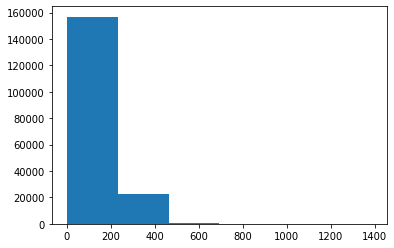

In [121]:
# Check distribution
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=6);

In [122]:
# Find 95% percentile
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [123]:
# Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [124]:
# Create char level token vectorizer

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [125]:
# Adapt char vectorizer to training characters

char_vectorizer.adapt(train_chars)

In [126]:
# Check character vocab stat
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters {char_vocab[-5:]}")

 Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters ['k', 'x', 'z', 'q', 'j']


In [127]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Char Text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized Chars:\n {vectorized_chars}")
print(f"\n Length of vectorized chars {len(vectorized_chars[0])}")

Char Text:
 t h e r e   w a s   n o   s i g n i f i c a n t   d i f f e r e n c e   i n   d e m o g r a p h i c   p a r a m e t e r s   (   p   >   @   )   .
Length of random_train_chars: 60

Vectorized Chars:
 [[ 3 13  2  8  2 20  5  9  6  7  9  4 18  6  4 17  4 11  5  6  3 10  4 17
  17  2  8  2  6 11  2  4  6 10  2 15  7 18  8  5 14 13  4 11 14  5  8  5
  15  2  3  2  8  9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character level embedding

In [128]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # Size of char embedding in the paper (Figure 1)
                              mask_zero=True,
                              name="char_embed")



In [129]:
# Test char embedding
print(f"Char text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded char: \n {char_embed_example}")
print(f" Char embedded shape: {char_embed_example.shape}")

Char text:
 t h e r e   w a s   n o   s i g n i f i c a n t   d i f f e r e n c e   i n   d e m o g r a p h i c   p a r a m e t e r s   (   p   >   @   )   .

Embedded char: 
 [[[ 0.01938966 -0.02040039  0.02507648 ... -0.00033814 -0.00477766
    0.0441835 ]
  [ 0.04850176  0.01071157  0.01231705 ... -0.03385192 -0.01296667
   -0.00266477]
  [-0.02329534  0.04978255 -0.02715456 ... -0.00153997  0.03766776
    0.02949698]
  ...
  [ 0.04963804  0.02723468  0.02617886 ...  0.01759741  0.00085723
    0.04152161]
  [ 0.04963804  0.02723468  0.02617886 ...  0.01759741  0.00085723
    0.04152161]
  [ 0.04963804  0.02723468  0.02617886 ...  0.01759741  0.00085723
    0.04152161]]]
 Char embedded shape: (1, 290, 25)


### Building a Conv1D Model for character level embedding

In [134]:
# Conv1D on chars

inputs = layers.Input(shape=(1,), dtype="string")

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(char_embeddings)
x= layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embed")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [135]:
model_3.summary()

Model: "model_3_conv1d_char_embed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_______________________________________

In [136]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [137]:
# Fit model

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2887 - accuracy: 0.4636 - val_loss: 1.1567 - val_accuracy: 0.5366
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.1150 - accuracy: 0.5392 - val_loss: 1.0535 - val_accuracy: 0.5715
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0269 - accuracy: 0.5867 - val_loss: 0.9733 - val_accuracy: 0.6190


In [138]:
# Make preds for character level

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1085339 , 0.30537266, 0.20318316, 0.28227994, 0.10063033],
       [0.24146006, 0.23995641, 0.02347356, 0.42476326, 0.07034673],
       [0.14309216, 0.29355833, 0.16770536, 0.30415124, 0.09149291],
       ...,
       [0.02395814, 0.0551561 , 0.08740126, 0.0312213 , 0.80226326],
       [0.06358877, 0.11851447, 0.59003896, 0.09092232, 0.13693553],
       [0.48002067, 0.33595154, 0.08193451, 0.07261787, 0.02947541]],
      dtype=float32)

In [140]:
# Conver pred probs to class labels

model_3_preds= tf.argmax(model_3_pred_probs, axis=1)
model_3_preds 

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 0])>

In [142]:
# Calculate reuslts for Conv1D Model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 60.83013372169999,
 'f1': 0.5971205378512771,
 'precision': 0.6083468678713004,
 'recall': 0.6083013372169999}

In [143]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}